based on 

https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import load_files
import models
from load_files import *
from models import *


Using TensorFlow backend.


In [3]:
x_train, y_train, x_test, y_test = load_dataset('../data/HAR/UCI_HAR_Dataset/')

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [4]:
x_train.shape

(7352, 128, 9)

In [5]:
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

keras imports

In [6]:
from keras import Model
from keras.layers import Lambda, Input, Dropout, Flatten, LSTM, Concatenate, Bidirectional, Conv1D
from keras import backend as K
from keras.callbacks import TensorBoard
from time import time
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from time import time

# Model generators

here we are going to analyse the performance of diffierent methods to classify the time series

here we define recall and auc metrics that are not implemented in keras

references:

https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras

In [7]:
import custom_metrics; from custom_metrics import as_keras_metric
import tensorflow as tf

auc_roc = as_keras_metric(tf.metrics.auc)
recall = as_keras_metric(tf.metrics.recall)

## Some callbacks

we define some callbacks that we are going to implement during training

https://stackoverflow.com/questions/50874596/how-to-detect-the-epoch-where-keras-earlystopping-occurred

In [14]:
#lr_cb = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_delta = 0.01, patience = 3, verbose = 1)
#es_cb = EarlyStopping(monitor = 'val_loss', min_delta=0.01, patience = 10, verbose = 1, restore_best_weights = True)

min_delta_val = 0.01
lr_cb = ReduceLROnPlateau(monitor = 'val_auc', mode='max', 
                          factor = 0.5, min_delta = min_delta_val, patience = 3, verbose = 1)
es_cb = EarlyStopping(monitor = 'val_auc', mode='max', 
                      min_delta=min_delta_val, patience = 10, verbose = 1, restore_best_weights = True)

default_callbacks = [lr_cb, es_cb]

Training parameters

In [15]:
from keras import optimizers

In [16]:
N_train = 1
adam = optimizers.adam(lr=0.01)
validation_split_on_training = 0.2
epochs = 100
batch_size = 1000

In [17]:
import models; from models import *

def generate_trained_models(model_type):
    
    print_summary_only_once = True
    trained_models = []
    trained_models_best_epoch = []
    trained_models_stats = []
    trained_models_time_taken = []

    model_name_base = model_type

    if model_type =='dense_2':
        model_generator = dense_model_2_generator
    elif model_type =='LSTM_2':
        model_generator = lstm_model_2_generator
    elif model_type =='dense':
        model_generator = dense_model_generator
    elif model_type =='LSTM':
        model_generator = lstm_model_generator
    elif model_type =='ens':
        model_generator = hybrid_ens_generator
    elif model_type =='dense_fc':
        model_generator = dense_fully_connected_model_generator        
    elif model_type =='conv_1d':
        model_generator = conv_1d_model_generator                
    else:
        raise ValueError('No model type found')
    
        
    for i in range(N_train):
        tic = time()
        model_name = model_name_base + '_' + str(i)
        tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
        callbacks_model = default_callbacks + [tensorboard]

        # generate model
        model_input, model_output , _ = model_generator(n_timesteps, n_features, n_outputs)
        model = Model(model_input, model_output, name = model_name)

        #compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', auc_roc, recall])
        if print_summary_only_once:
            model.summary()
            print_summary_only_once = False

        # train model
        model.fit(x_train, 
                  y_train, epochs=epochs, 
                  batch_size=batch_size, 
                  validation_split=validation_split_on_training,
                  verbose=True,
                  callbacks = callbacks_model)     
        trained_models.append(model)

        # training time
        training_time = time()-tic
        trained_models_time_taken.append(training_time)
        print('training time: {}s'.format(training_time))

        # early stopping epoch
        best_epoch = es_cb.stopped_epoch
        trained_models_best_epoch.append(best_epoch)

        #append best stat
        best_stats = {}
        for key in model.history.history.keys():
            best_stats[key] = model.history.history[key][best_epoch]
        trained_models_stats.append(best_stats)
    
    trained_models_stats = pd.DataFrame(trained_models_stats)
    return trained_models, trained_models_stats, trained_models_time_taken, trained_models_best_epoch

In [ ]:
model_types = [ 'LSTM_2','dense_2','dense', 'LSTM', 'ens', 'dense_fc','conv_1d']
trainig_reulsts = {}

for model_name in model_types:
    
    trained_models, trained_models_stats, trained_models_time_taken, trained_models_best_epoch = generate_trained_models(model_name)
    stats_best_epoch = pd.DataFrame(trained_models_best_epoch, columns=['epoch']).mean()
    stats_time_takes = pd.DataFrame(trained_models_time_taken, columns=['time']).mean()
    stats_best_stats = pd.DataFrame(trained_models_stats).mean()

    trainig_reulsts[model_name] = {'trained_models': trained_models,
                                  'trained_models_stats': trained_models_stats,
                                  'trained_models_time_taken': trained_models_time_taken,
                                  'trained_models_best_epoch': trained_models_best_epoch,
                                  'stats_best_epoch': stats_best_epoch,
                                  'stats_time_takes': stats_time_takes,
                                  'stats_best_stats': stats_best_stats}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 9)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 200)          88000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               24120     
_________________________________________________________________
lstm_out (Dense)             (None, 6)                 726       
Total params: 353,646
Trainable params: 353,646
Non-trainable params: 0
_________________________________________________________________
Trai

_____
model: dense 

mean best epoc: [13.3]
mean training time: [15.00403929]
STATS:
acc           0.966349
auc           0.991525
loss          0.071253
lr            0.000125
recall        1.000000
val_acc       0.901835
val_auc       0.991543
val_loss      0.576617
val_recall    1.000000
dtype: float64




<IPython.core.display.Javascript object>


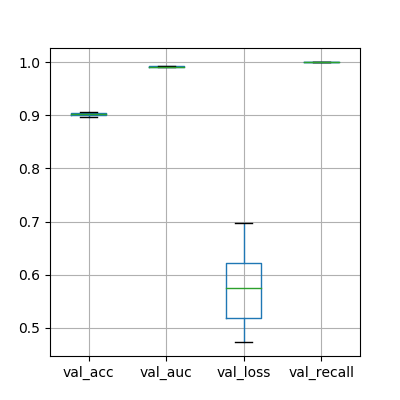

_____
model: LSTM 

mean best epoc: [26.8]
mean training time: [318.02784545]
STATS:
acc           0.959973
auc           0.986427
loss          0.097603
lr            0.000038
recall        1.000000
val_acc       0.907002
val_auc       0.986574
val_loss      0.514009
val_recall    1.000000
dtype: float64




<IPython.core.display.Javascript object>


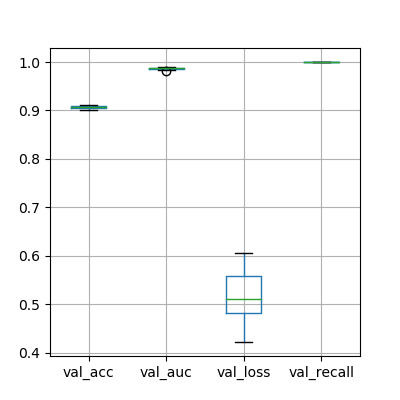

_____
model: ens 

mean best epoc: [13.]
mean training time: [195.64047744]
STATS:
acc           0.964343
auc           0.991054
loss          0.076536
lr            0.000125
recall        1.000000
val_acc       0.903739
val_auc       0.991089
val_loss      0.506064
val_recall    1.000000
dtype: float64




<IPython.core.display.Javascript object>


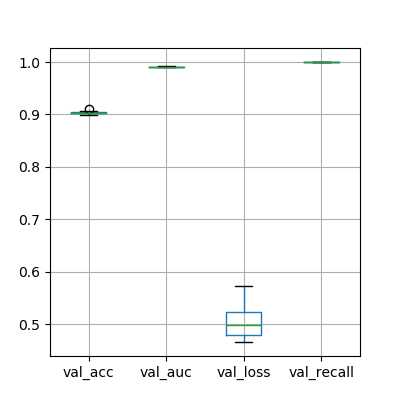

In [21]:
for model_name in trainig_reulsts.keys():
    print('_____')
    print('model: {} \n'.format(model_name))
    print('mean best epoc: {}'.format(trainig_reulsts[model_name]['stats_best_epoch'].values))
    print('mean training time: {}'.format(trainig_reulsts[model_name]['stats_time_takes'].values))
    
    print('STATS:')
    
    print(trainig_reulsts[model_name]['stats_best_stats'])
    print('\n')

    plt.figure(figsize = (4,4))
    stats_for_model = trainig_reulsts[model_name]['trained_models_stats']
    stats_for_model[stats_for_model.columns[stats_for_model.columns.str.contains(pat = 'val')]].boxplot()
    

In [22]:
stats_for_model[['val_auc']].values.ravel()

array([0.99071633, 0.99149563, 0.99084383, 0.99098311, 0.99096847,
       0.99073924, 0.99200126, 0.99187763, 0.99069375, 0.99056988])

<IPython.core.display.Javascript object>


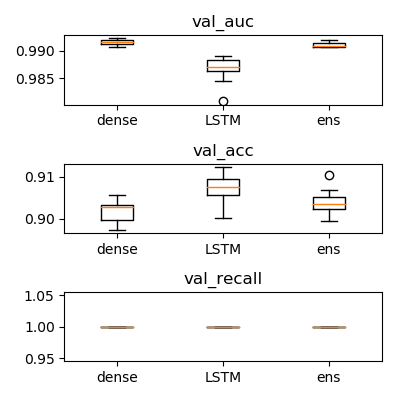

val_auc
dense	0.9915426188711404
LSTM	0.9865744103224889
ens	0.9910889124845988
val_acc
dense	0.901835486282709
LSTM	0.9070020412037276
ens	0.903738953927842
val_recall
dense	1.0
LSTM	1.0
ens	1.0


In [38]:
plt.figure(figsize = (4,4))
model_names = trainig_reulsts.keys()
for i, metric in enumerate(['val_auc', 'val_acc', 'val_recall']):
    plt.subplot(3,1,i+1)
    plt.title(metric)
    which = 'trained_models_stats'
    plot_metrics = [trainig_reulsts[model_name][which][metric] for model_name in model_names]
    plt.boxplot(plot_metrics, labels= model_names)
    plt.tight_layout()    
    print(metric)
    for model_name in model_names:
        print(model_name + '\t' + str(trainig_reulsts[model_name]['stats_best_stats'][metric]))

In [ ]:
model_name = 'dense'
trained_models = []

print_summary_only_once = True
best_model_epoch = []
trained_models_stats = []
trained_models_time_taken = []


for i in range(N_train):
    tic = time()
    model_name = model_name + '_' + str(i)
    tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
    callbacks_model = callbacks + [tensorboard]

    # generate model
    model_input, model_output , _ = dense_model_generator(n_timesteps, n_features)
    model = Model(model_input, model_output, name = model_name)
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', auc_roc, recall])
    if print_summary_only_once:
        model.summary()
        print_summary_only_once = False
    
    # train model
    model.fit(x_train, 
              y_train, epochs=epochs, 
              batch_size=batch_size, 
              validation_split=validation_split_on_training,
              verbose=True,
              callbacks = callbacks_model)     
    trained_models.append(model)
    
    # training time
    training_time = time()-tic
    trained_models_time_taken.append(training_time)
    print('training time: {}s'.format(training_time))
    
    # early stopping epoch
    best_epoch = es_cb.stopped_epoch
    best_model_epoch.append(best_epoch)
    
    #append best stat
    best_stats = {}
    for key in model.history.history.keys():
        best_stats[key] = model.history.history[key][best_epoch]
    trained_models_stats.append(best_stats)

In [ ]:
model_name = 'dense'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_dense = callbacks + [tensorboard]

#generate model
dense_input, dense_output , _ = dense_model_generator(n_timesteps, n_features)
model = Model(dense_input, dense_output, name = model_name)

#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(x_train, 
          y_train, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_dense)

In [ ]:
model_name = 'LSTM'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_lstm = callbacks + [tensorboard]

lstm_input, lstm_output, _  = lstm_model_generator(n_timesteps, n_features)

model = Model(lstm_input, lstm_output, name= model_name )
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, 
          y_train, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_lstm)


### Dense network approach

some comments about this architecture:

- Note that the unstack dim is the feature dimension

In [ ]:
model_name = 'dense'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_dense = callbacks + [tensorboard]

#generate model
dense_input, dense_output , _ = dense_model_generator(n_timesteps, n_features)
model = Model(dense_input, dense_output, name = model_name)

#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(x_train, 
          y_train, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_dense)

# Hybrid ensemble

In [ ]:
model_name = 'ens'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_ens = callbacks + [tensorboard]

ens_input, ens_output, _  = hibrid_ens_generator(n_timesteps, n_features)


model = Model(ens_input, ens_output, name= model_name)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(x_train, 
          y_train, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_ens)

